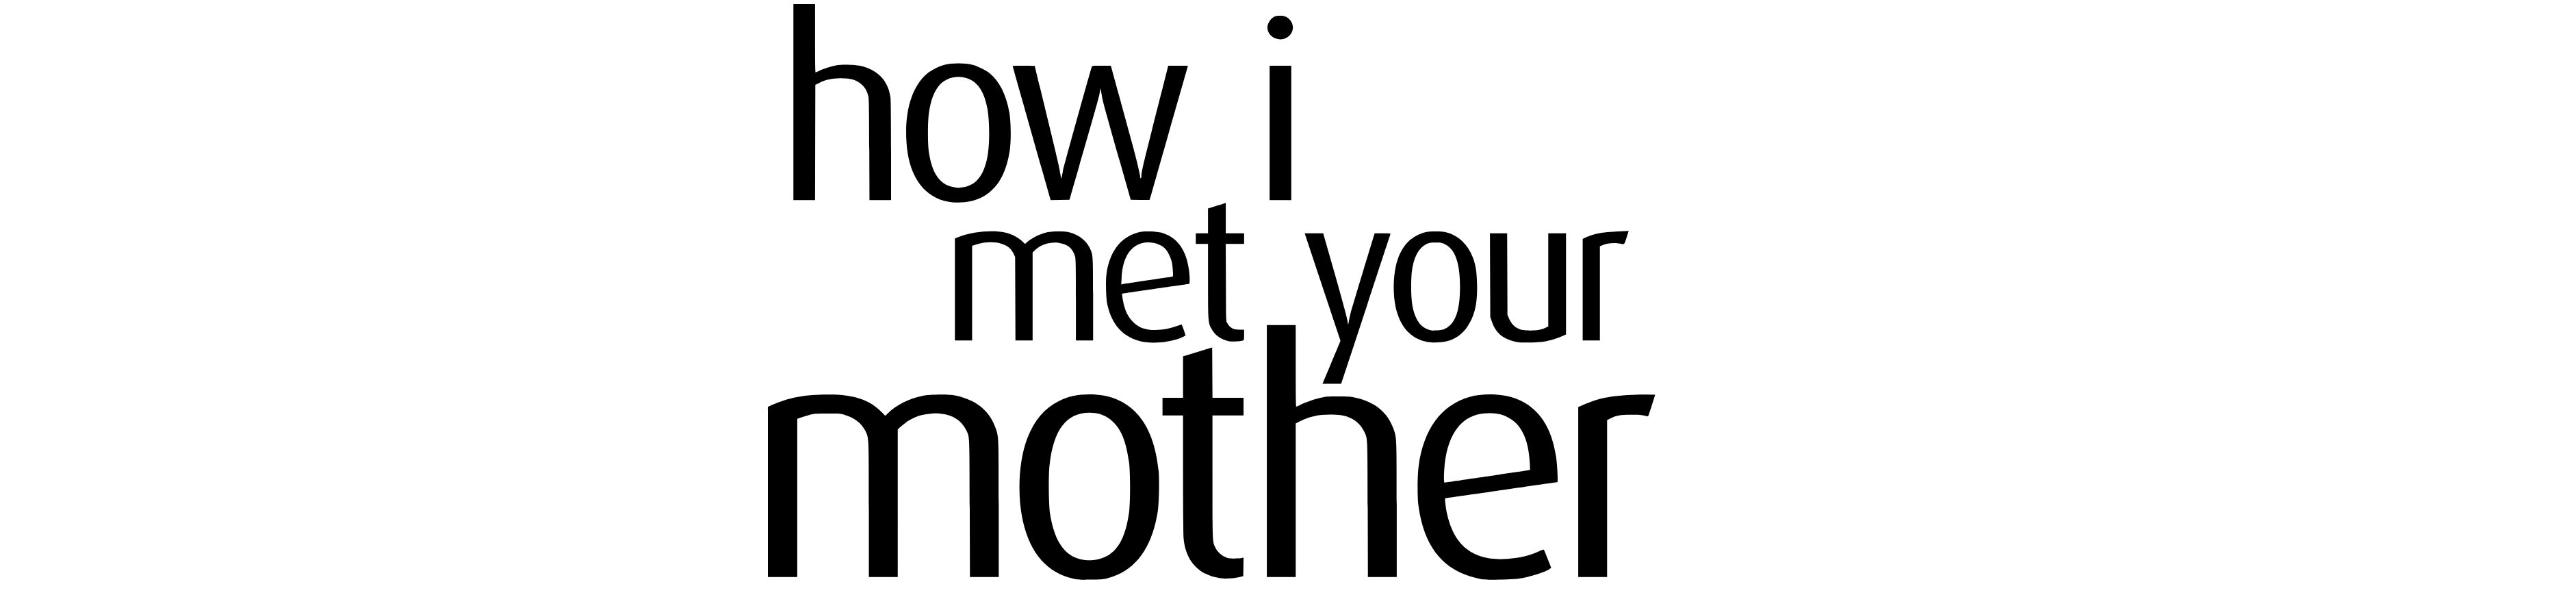

***

In [1]:
# Libraries I used

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')


# <span style='background :yellow' > Uploading the data </span>

In [2]:
data = pd.read_csv("himym_dataset.csv")
script = pd.read_csv("himym_transcripts.csv")

In [3]:
data.head()

SNo  Season  Episode           DateAired                   Title  \
0    1       1        1  September 19, 2005                   Pilot   
1    2       1        2  September 26, 2005          Purple Giraffe   
2    3       1        3     October 3, 2005  Sweet Taste of Liberty   
3    4       1        4    October 10, 2005     Return of the Shirt   
4    5       1        5    October 17, 2005            Okay Awesome   

        Director                   Writers  Viewers  IMDB_Rating  Votes  
0  Pamela Fryman  Carter Bays,Craig Thomas    10.94          8.5   4935  
1  Pamela Fryman  Carter Bays,Craig Thomas    10.40          8.2   3708  
2  Pamela Fryman    Phil Lord,Chris Miller    10.44          8.2   3514  
3  Pamela Fryman             Kourtney Kang     9.84          8.0   3298  
4  Pamela Fryman              Chris Harris    10.14          8.3   3412

In [4]:
script.head()

episode    name  \
0  4x02 - The Best Burger in New York  Barney   
1  4x02 - The Best Burger in New York     Ted   
2  4x02 - The Best Burger in New York  Barney   
3  4x02 - The Best Burger in New York    Lily   
4  4x02 - The Best Burger in New York     Ted   

                                                line  
0   Goliath National Bank. The world leader in cr...  
1   Okay, first of all, you look like the last pi...  
2   Our company just bought them out in a ruthles...  
3   Barney, Marshall didn't quit his last soul-su...  
4      So, what do you guys want to do for dinner?\n

In [5]:
# checking for any NULLs

data.info()
print('\n' + '_'*55 + '\n')
script.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SNo          208 non-null    int64  
 1   Season       208 non-null    int64  
 2   Episode      208 non-null    int64  
 3   DateAired    208 non-null    object 
 4   Title        208 non-null    object 
 5   Director     208 non-null    object 
 6   Writers      208 non-null    object 
 7   Viewers      208 non-null    float64
 8   IMDB_Rating  208 non-null    float64
 9   Votes        208 non-null    int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 16.4+ KB

_______________________________________________________

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24010 entries, 0 to 24009
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   episode  24010 non-null  object
 1   name     24010 non-null  object
 2   line     

In [6]:
script.describe()

episode   name   line
count             24010  24010  24010
unique              133      5  21899
top     2x09 - Slap Bet    Ted     \n
freq                288   6449    146

In [7]:
script['name'].unique()

array(['Barney', 'Ted', 'Lily', 'Robin', 'Marshall'], dtype=object)

### Two points are obtained from the above two cells:
- The script only contains the lines of the 5 main characters. 
- The script we have is from the first 6 seasons or so (Not all 9 seasons. Look at the number of unique episodes in the 'script' DF description, there're 133 not 208!).

***

# <span style='background :yellow' > Cleaning the data </span>

In [8]:
# renaming column 'DateAired' to 'Date'
data.rename(columns = {'DateAired': 'Date'}, inplace=True)

# renaming column 'Viewers' to 'Viewers(millions)'
data.rename(columns = {'Viewers': 'US Viewers(millions)'}, inplace=True)

#creating new columns 'title' and 'season' by slicing from column 'episode'
script['title'] = script['episode'].str[7:]
script['season'] = script['episode'].str[:1]

# cleaning column 'episode' 
script['episode'] = script['episode'].str[2:4]
script['episode'] = script['episode'].str.lstrip('0')

# changing the order of the columns in the 'script' dataframe 
cols = ['season', 'episode','title', 'name', 'line']
script = script[cols] 

# sorting the 'script' DF by the two columns 'season' and 'episode'
script = script.sort_values(['season', 'episode'], ascending = [True, True])

# resetting the index
script = script.reset_index(drop = True)

In [9]:
data.head()

SNo  Season  Episode                Date                   Title  \
0    1       1        1  September 19, 2005                   Pilot   
1    2       1        2  September 26, 2005          Purple Giraffe   
2    3       1        3     October 3, 2005  Sweet Taste of Liberty   
3    4       1        4    October 10, 2005     Return of the Shirt   
4    5       1        5    October 17, 2005            Okay Awesome   

        Director                   Writers  US Viewers(millions)  IMDB_Rating  \
0  Pamela Fryman  Carter Bays,Craig Thomas                 10.94          8.5   
1  Pamela Fryman  Carter Bays,Craig Thomas                 10.40          8.2   
2  Pamela Fryman    Phil Lord,Chris Miller                 10.44          8.2   
3  Pamela Fryman             Kourtney Kang                  9.84          8.0   
4  Pamela Fryman              Chris Harris                 10.14          8.3   

   Votes  
0   4935  
1   3708  
2   3514  
3   3298  
4   3412

In [10]:
script.head()

season episode  title      name  \
0      1       1  Pilot  Marshall   
1      1       1  Pilot       Ted   
2      1       1  Pilot  Marshall   
3      1       1  Pilot       Ted   
4      1       1  Pilot  Marshall   

                                                line  
0                               Will you marry me.\n  
1   Yes, perfect! And then you're engaged, you po...  
2   Got it. Thanks for helping me plan this out, ...  
3   Dude, are you kidding? It's you and Lily! I'v...  
4         yeah, sorry. We thought you were asleep.\n

---

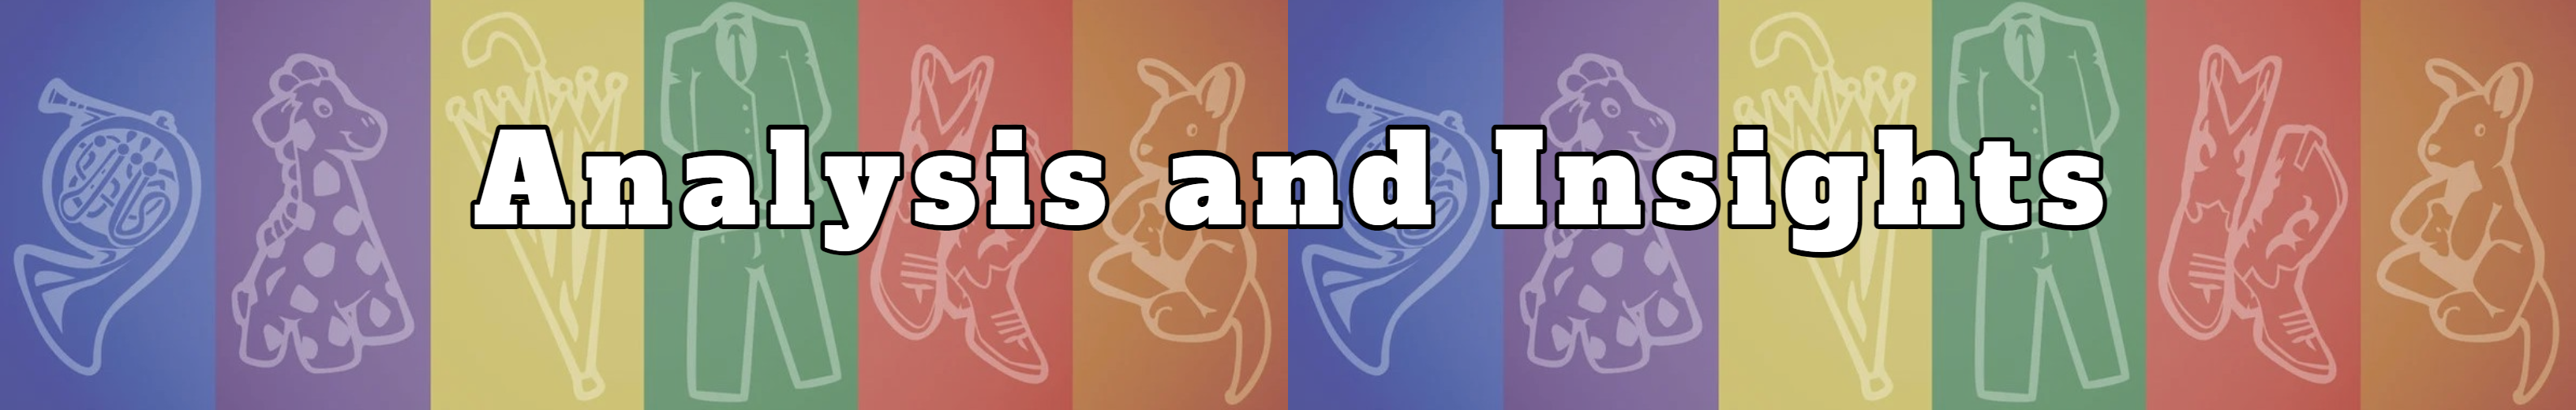

In [11]:
#------------------------------ some numbers --------------------------------
episodes =len(data['Episode'])

fig = make_subplots(rows=1, cols=2)
fig.add_trace(go.Indicator(
    mode = "number",
    number={'font':{'color': "#ffffff",'size':85}},
    title = {"text": "<span style='font-size:2em;color:grey'>Number of</span>"},
    domain = {'x': [0.4, 0.5], 'y': [0.7, 1]}))

fig.add_trace(go.Indicator(
    mode = "number",
    value = data["Season"].nunique(),
    number={'font':{'color': "#9b81eb",'size':100}},
    title = {"text": "<span style='font-size:3em;color:grey'>Seasons</span>"},
    domain = {'x': [0, 0.4], 'y': [0.3, 0.5]}))

fig.add_trace(go.Indicator(
    mode = "number",
    value = episodes,
    number={'font':{'color': "#9b81eb",'size':100}},
    title = {"text": "<span style='font-size:3em;color:grey'>Episodes</span>"},
    domain = {'x': [0.5, 1], 'y': [0.3, 0.5]}))

fig.show()

#------------------------------ pie chart --------------------------------
data1 = data.copy()
episode_count = data1.groupby("Season")["Episode"].value_counts().to_frame().rename(columns={"Episode":"count"}).reset_index()
labels = "Season"+" "+episode_count["Season"].apply(str).unique()

values = []
for i in range(1, 10):
    num = len(episode_count[episode_count['Season']==i])
    values.append(num)

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_traces(hoverinfo='label+value', textinfo='label+value', textfont_size=12,
                  marker=dict(line=dict(color='#808080', width=1)))
fig.show()

---

# <span style='background :yellow' > Directors </span>

In [12]:
print(data['Director'].unique())
print('Number of directors: '+str(len(data['Director'].unique())))

['Pamela Fryman' 'Rob Greenberg' 'Michael Shea' 'Neil Patrick Harris']
Number of directors: 4


# Fact: This show has been direcred by 4 different directors

In [13]:
data_directors = data.copy()
data_directors['Season']= 'Season' + ' ' + data_directors['Season'].apply(str)
data_directors = data_directors.dropna(subset=['Director'], axis=0)
data_directors['newCol'] = data_directors['Episode'].apply(str) + ' - ' + data_directors['Title'].apply(str)

fig = px.sunburst(data_directors,
                  path=['Director', 'Season','newCol'])
fig.update_layout(width=650, height=650)
fig.show()

***

## Fact: _Pamela Fryman_ directed most of the episodes with a total of 196 episodes. While _Neil Patrick Harris_ directed only one episode (Season 5 ep 13 - Jenkins)!


In [14]:
data[data['Title']=='Jenkins']

SNo  Season  Episode              Date    Title             Director  \
100  101       5       13  January 18, 2010  Jenkins  Neil Patrick Harris   

         Writers  US Viewers(millions)  IMDB_Rating  Votes  
100  Greg Malins                 10.52          8.6   2717

In [15]:
df = pd.DataFrame(data['IMDB_Rating'].value_counts())
df.sort_index(ascending=False, inplace = True)
df2 = df.iloc[:10]
df2.style.background_gradient(cmap='Reds')

In [16]:
df = pd.DataFrame(data['US Viewers(millions)'].value_counts())
df.sort_index(ascending=False, inplace = True)
df2 = df.iloc[:20]
df2.style.background_gradient(cmap='Blues')

## Fact: According to the above two cells, the only episode directed by _Neil Patrick Harris_ got a quite high rating (one of the top 10), Also it's one of the most viewed episodes (in the top 20)!   And it's highlighted in the charts below

***

# <span style='background :yellow'> What are the top 30 most *viewed* episodes? <span>

In [17]:
most_viewed_30= data.sort_values(by = ['US Viewers(millions)'], ascending=False).iloc[:30,:]
colors = ['#696969',] * 30
colors[-10] = 'crimson'

fig = go.Figure(data=[go.Bar(x=most_viewed_30['Title'], y=most_viewed_30['US Viewers(millions)'],
                             marker_color=colors, width=[0.6]*30)])
fig.update_layout(title_text="Top 30 most viewed 'HIMYM' episodes", xaxis_title='Episode Title',
                  yaxis_title='Viewers(millions)', height=750, bargroupgap=0.1)
fig.show()

# <span style='background :yellow'> What are the top 30 most *rated* episodes? <span>

In [18]:
most_viewed_45= data.sort_values(by = ['IMDB_Rating'], ascending=False).iloc[:45,:]
colors = ['#696969',] * 45
colors[-4] = 'crimson'

fig = go.Figure(data=[go.Bar(x=most_viewed_45['Title'], y=most_viewed_45['IMDB_Rating'],
                             marker_color=colors, width=[0.6]*45)])
fig.update_layout(title_text="Top rated 45 'HIMYM' episodes", xaxis_title='Episode Title',
                  yaxis_title='IMDB_Rating (out of 10)', height=750, bargroupgap=0.1)
fig.show()

# <span style='background :yellow'> Average views and ratings for each director: <span>

In [19]:
mask1=data_directors['Director']== 'Pamela Fryman'
mask2=data_directors['Director']== 'Rob Greenberg'
mask3=data_directors['Director']== 'Michael Shea'
mask4=data_directors['Director']== 'Neil Patrick Harris'


data_director_com= data_directors[mask1|mask2|mask3|mask4]
dir_view_rat= data_director_com.groupby('Director')['US Viewers(millions)', 'IMDB_Rating'].mean().sort_values(by='US Viewers(millions)', ascending=False)
dir_view_rat['US Viewers(millions)']=dir_view_rat['US Viewers(millions)'].round(2)
dir_view_rat['IMDB_Rating']=dir_view_rat['IMDB_Rating'].round(2)

In [20]:
fig = make_subplots(rows=1, cols=2, specs=[[{}, {}]], shared_xaxes=True,shared_yaxes=False, vertical_spacing=0.001)

fig.append_trace(go.Bar(x = dir_view_rat['US Viewers(millions)'], y = dir_view_rat.index,
                        marker = dict(color='#0054a6',line=dict(color='rgb(8,48,107)',width=1),opacity=0.6),
                        name = 'Average Viewers (in millions) for episodes', orientation='h',), 1, 1)

fig.append_trace(go.Bar(x=dir_view_rat['IMDB_Rating'], y=dir_view_rat.index,
                        marker=dict(color='#fff200',line=dict(color='rgb(8,48,107)',width=1),opacity=0.6),
                        name='Average Rating (out of 10) for episodes', orientation='h',), 1, 2)

fig.update_layout(
    title='Directors who directed HIMYM',
    yaxis=dict(showgrid=False,showline=False,showticklabels=True,domain=[0, 0.85]),
    yaxis2=dict(showgrid=False,showline=True,showticklabels=False,domain=[0, 0.85]),
    xaxis=dict(zeroline=False, showline=False,showticklabels=True,showgrid=True,domain=[0, 0.42]),
    xaxis2=dict(zeroline=False,showline=False,showticklabels=True,showgrid=True,domain=[0.47, 1]),
    legend=dict(x=0.029, y=1.038, font_size=10),margin=dict(l=100, r=20, t=70, b=70),
    paper_bgcolor='rgb(248, 248, 255)',plot_bgcolor='rgb(248, 248, 255)')

fig.show()

***

# <span style='background :yellow'> Average Views:

In [21]:
#---------------------------------------------- seasons -------------------------------------------------------

viewers_per_season= data.groupby("Season")["US Viewers(millions)"].mean().to_frame().reset_index()
viewers_per_season["US Viewers(millions)"]= viewers_per_season["US Viewers(millions)"].round(2)

fig= px.scatter(viewers_per_season, x="Season", y="US Viewers(millions)", 
                size="US Viewers(millions)", color="Season", hover_name= "Season", size_max=40, 
                title="Season Viewers")
fig.update_layout(uniformtext_minsize=7, uniformtext_mode='hide', xaxis_title="Seasons",
                  yaxis_title="Average Viewers(millions)")
fig.show()

#------------------------------------------------ episodes -------------------------------------------------------

fig2= px.scatter(data, x="Episode", y="US Viewers(millions)", color="Season", 
                 hover_name= "Title", size_max=40, 
                title="Episode Viewers")
fig2.update_layout(uniformtext_minsize=7, uniformtext_mode='hide', 
                   xaxis_title="Episodes",yaxis_title="Viewers(millions)")
fig2.show()

# Fact: The most viewed season is the 1st one, while the least viewed season is the 8th! (from the 1st plot shown above) 
# Also, notice that almost every season shows a regular pattern where there is a noticeable increase in views during the middle part of the season and a decrease at the end! (look at the 2nd plot)

In [22]:
fig=px.line(data, x="Date", y="US Viewers(millions)", color="Season", markers=True)
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

***

# <span style='background :yellow'> Average Rates:

In [23]:
#---------------------------------------------- seasons -------------------------------------------------------

rating_per_season = data.groupby("Season")["IMDB_Rating"].mean().to_frame().reset_index()
rating_per_season["IMDB_Rating"]= rating_per_season["IMDB_Rating"].round(2)

fig= px.scatter(rating_per_season, x="Season", y="IMDB_Rating", 
                size="IMDB_Rating", color="Season", hover_name= "Season", size_max=40, 
                title="Average Season Ratings")
fig.update_layout(uniformtext_minsize=7, uniformtext_mode='hide', xaxis_title="Seasons",
                  yaxis_title="Average Ratings")
fig.show()

#------------------------------------------------ episodes -------------------------------------------------------

fig2= px.scatter(data, x="Episode", y="IMDB_Rating", color="Season", 
                 hover_name= "Title", size_max=40, 
                title="Average Episode Ratings")
fig2.update_layout(uniformtext_minsize=7, uniformtext_mode='hide', 
                   xaxis_title="Episodes",yaxis_title="Ratings")
fig2.show()

# Fact: There is a clear trend of decreasing in rates as the seasons progress.
# Another Fact: All poorly rated episodes are from season 9!

***

# <span style='background :yellow' > Writers</span>

In [24]:
print(data['Writers'].unique())
print('Number of directors: '+str(len(data['Writers'].unique())))

['Carter Bays,Craig Thomas' 'Phil Lord,Chris Miller' 'Kourtney Kang'
 'Chris Harris' 'Brenda Hsueh' 'Sam Johnson,Chris Marcil'
 'Gloria Calderon Kellett' 'Maria Ferrari' 'Ira Ungerleider'
 'Stephen Lloyd' 'Kristen Newman' 'Jamie Rhonheimer' 'Greg Malins'
 'Matt Kuhn' 'David Hemingson' 'Jonathan Groff'
 'Chris Harris, Carter Bays,Craig Thomas' 'Joe Kelly'
 'Jonathan Groff,Chris Harris' 'Robia Rashid' 'Theresa Mulligan Rosenthal'
 'Chuck Tatham' 'Craig Gerard,Matthew Zinman' 'Jennifer Hendriks'
 'Tami Sagher' 'Tom Ruprecht' 'Dan Gregor,Doug Mand' 'George Sloan'
 'Eric Falconer,Romanski' 'Barbara Adler' 'Rachel Axler']
Number of directors: 31


# Fact: This show has been written by 31 different writers

In [25]:
data_writers = data.copy()
data_writers.dropna(subset=["Writers"], axis=0, inplace=True)
writer_count = data_writers["Writers"].value_counts().to_frame().reset_index().rename(columns={"index":"Writers", "Writers":"number of episodes"})

fig = px.sunburst(writer_count,
                  path=["number of episodes",'Writers'], 
                  values='number of episodes',
                  color='number of episodes',
                  color_continuous_scale="Viridis")
                 
fig.update_layout(title_text="Number of episodes vs writers", 
                  titlefont={'size': 25},
                  width=600, height=600)
fig.show()

# Fact: _Carter Bays and Craig Thomas_ wrote the most episodes with a total of 66 episodes.

***

# <span style='background :yellow' > Now let's see the script data. </span>
### <span style='background :yellow' > Keep in mind that this data only contains the first 6 seasons and a couple episodes from season 7! </span>

# <span style='background :yellow' > Script cleaning </span>

In [26]:
script.head()

season episode  title      name  \
0      1       1  Pilot  Marshall   
1      1       1  Pilot       Ted   
2      1       1  Pilot  Marshall   
3      1       1  Pilot       Ted   
4      1       1  Pilot  Marshall   

                                                line  
0                               Will you marry me.\n  
1   Yes, perfect! And then you're engaged, you po...  
2   Got it. Thanks for helping me plan this out, ...  
3   Dude, are you kidding? It's you and Lily! I'v...  
4         yeah, sorry. We thought you were asleep.\n

In [27]:
cleaned_script = script.copy()
cleaned_script.dropna(inplace = True)

stopword = nltk.corpus.stopwords.words('english')

def clean_text(text):
    cleaned_text = re.sub("^\s|\s$","",re.sub("[^a-zA-Z]", " ", text))
    cleaned_text = cleaned_text.lower()
    return cleaned_text

In [28]:
cleaned_script['line']= cleaned_script['line'].apply(lambda x: clean_text(x))
cleaned_script.head()

season episode  title      name  \
0      1       1  Pilot  Marshall   
1      1       1  Pilot       Ted   
2      1       1  Pilot  Marshall   
3      1       1  Pilot       Ted   
4      1       1  Pilot  Marshall   

                                                line  
0                                 will you marry me   
1  yes  perfect  and then you re engaged  you pop...  
2  got it  thanks for helping me plan this out  ted   
3  dude  are you kidding  it s you and lily  i ve...  
4           yeah  sorry  we thought you were asleep

# <span style='background :yellow' > What words did our 5 main characters say the most?

In [29]:
most_common = cleaned_script.copy()

def clean_text2(text):
    word1= text.split()
    word= [word for word in word1 if not word in stopword]
    word= " ".join(word)
    return word

most_common['line']= most_common['line'].apply(lambda x: clean_text2(x))

In [30]:
most_common['name'].unique()

array(['Marshall', 'Ted', 'Barney', 'Lily', 'Robin'], dtype=object)

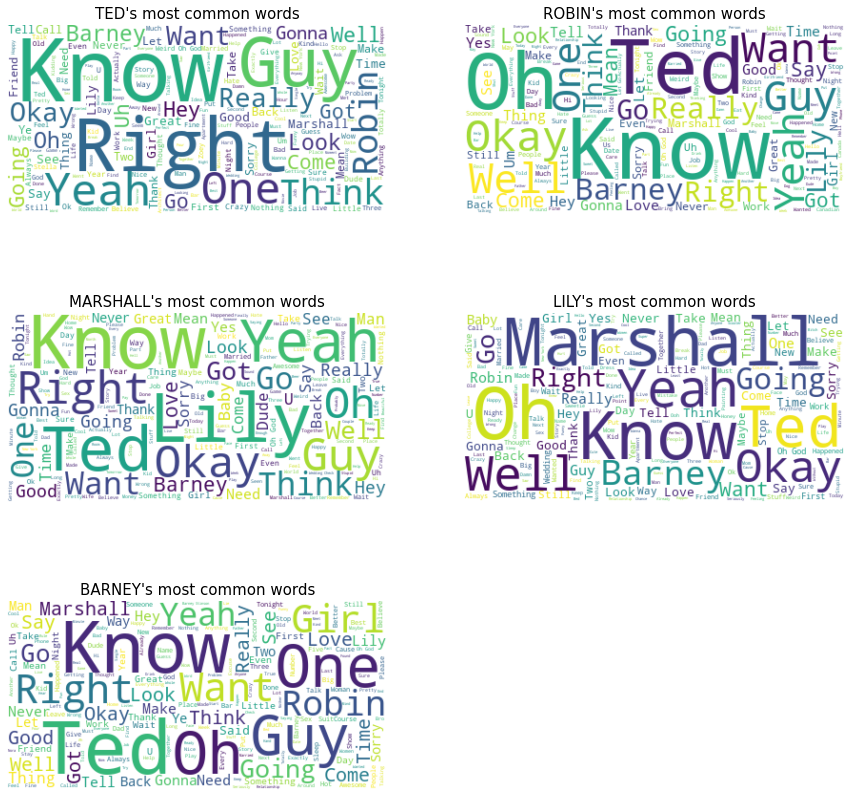

In [31]:
i=1
name_list = ['Ted', 'Robin', 'Marshall', 'Lily', 'Barney']
fig,axes= plt.subplots(2,2,figsize=(15,15))

for name in name_list:
    plt.subplot(3,2,i)
    name_=most_common[most_common['name'].str.contains(name)]
    text_combined= ', '.join(name_['line'])
    wordcloud = WordCloud(background_color="white").generate(text_combined.title())
    
    plt.title("{}'s most common words".format(str.upper(name)),size= 15)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    i=i+1
plt.show()

# <span style='background :#dbaaa4' > Who mentioned " ..... " the most? <span>
- 'Ted' mentioned 'Robin' the most.
- 'Robin' mentioned 'Ted' the most.
- 'Marshall' mentioned 'Lily' the most.
- 'Lilly' mentioned 'Marshall' the most.
- 'Barney' mentioned 'Ted' the most. 

***

# <span style='background :yellow' > Catch-phrases of HIMYM cast and how many times did they actually say over the course of the 6 seasons

In [32]:
script2 = script.copy()
script2['line'] = script['line'].str.lower()

In [33]:
# Barney
suit_up = script2[script2["name"].str.contains("Barney") & script2["line"].str.contains("suit") & script2["line"].str.contains("up")]
suit_up_count = len(suit_up)

what_up = script2[script2["name"].str.contains("Barney") & script2["line"].str.contains("what") & script2["line"].str.contains("up")]
what_up_count = len(what_up)

awesome = script2[script2["name"].str.contains("Barney") & script2["line"].str.contains("awesome")]
awesome_count = len(awesome)

legendary = script2[script2["name"].str.contains("Barney") & script2["line"].str.contains("legen")]
legendary_count = len(legendary)

please = script2[script2["name"].str.contains("Barney") & script2["line"].str.contains("please")]
please_count = len(please)

true_story = script2[script2["name"].str.contains("Barney") & script2["line"].str.contains("true story")]
true_story_count = len(true_story)

have_you_met = script2[script2["name"].str.contains("Barney") & script2["line"].str.contains("have you met*")]
have_you_met_count = len(have_you_met)

challenge_accepted = script2[script2["name"].str.contains("Barney") & script2["line"].str.contains("challenge accept")]
challenge_accepted_count = len(challenge_accepted)

# Marshall
lawyered = script2[script2["name"].str.contains("Marshall") & script2["line"].str.contains("lawyered")]
lawyered_count = len(lawyered)

# Robin
umm = script2[script2["name"].str.contains("Robin") & script2["line"].str.contains("umm")]
umm_count = len(umm)

# Ted
fun_fact = script2[script2["name"].str.contains("Ted") & script2["line"].str.contains("fun fact")]
fun_fact_count = len(fun_fact)

# Lily
wheres_the_poop = script2[script2["name"].str.contains("Lily") & script2["line"].str.contains("poop")]
wheres_the_poop_count = len(wheres_the_poop)

marshmallow = script2[script2["name"].str.contains("Lily") & script2["line"].str.contains("marshmallow")]
marshmallow_count = len(marshmallow)
 

In [34]:
fig = go.Figure()

fig.add_trace(go.Indicator(
    mode = "number",
    number={'font':{'color': "#171717",'size':100}},
    title = {"text": "<span style='font-size:2em;color:#9ab973'>Barney's Catch-phrases:</span>"},
    domain = {'row': 1, 'column': 1}))

fig.add_trace(go.Indicator(
    mode = "number",
    value = suit_up_count,
    number={'font':{'color': "#AF7AC5",'size':50}},
    title = {"text": "<span style='font-size:2em;color:#800080'>'Suit up!'</span>"},
    domain = {'row': 2, 'column': 0}))

fig.add_trace(go.Indicator(
    mode = "number",
    value = what_up_count,
    number={'font':{'color': "pink",'size':50}},
    title = {"text": "<span style='font-size:2em;color:#FF1493'>'What up!'</span>"},
    domain = {'row': 2, 'column': 2}))

fig.add_trace(go.Indicator(
    mode = "number",
    value = awesome_count,
    number={'font':{'color': "#88d8c0",'size':50}},
    title = {"text": "<span style='font-size:2em;color:#48d1cc'>'Awesome!'</span>"},
    domain = {'row': 4, 'column': 1}))

fig.add_trace(go.Indicator(
    mode = "number",
    value = legendary_count,
    number={'font':{'color': "#7cb9e8",'size':50}},
    title = {"text": "<span style='font-size:2em;color:#779ecb'>'Legen.. Wait for it.. dary!'</span>"},
    domain = {'row': 6, 'column': 0}))

fig.add_trace(go.Indicator(
    mode = "number",
    value = please_count,
    number={'font':{'color': "#ffa07a",'size':50}},
    title = {"text": "<span style='font-size:2em;color:#ff7f50'>'PLEASE!'</span>"},
    domain = {'row': 6, 'column': 2}))

fig.add_trace(go.Indicator(
    mode = "number",
    value = true_story_count,
    number={'font':{'color': "#AF7AC5",'size':50}},
    title = {"text": "<span style='font-size:2em;color:#800080'>'True Story'</span>"},
    domain = {'row': 8, 'column': 1}))

fig.add_trace(go.Indicator(
    mode = "number",
    value = have_you_met_count,
    number={'font':{'color': "#ffa07a",'size':50}},
    title = {"text": "<span style='font-size:2em;color:#ff7f50'>'Have you met...'</span>"},
    domain = {'row': 10, 'column': 0}))

fig.add_trace(go.Indicator(
    mode = "number",
    value = challenge_accepted_count,
    number={'font':{'color': "#acbf60",'size':50}},
    title = {"text": "<span style='font-size:2em;color:#9ab973'>'Challenge Accepted!'</span>"},
    domain = {'row': 10, 'column': 2}))


fig.update_layout({'paper_bgcolor': '#171717'})
fig.update_layout(grid = {'rows': 12, 'columns': 3})
fig.show()

In [35]:
fig = go.Figure()

fig.add_trace(go.Indicator(
    mode = "number",
    number={'font':{'color': "#171717",'size':90}},
    title = {"text": "<span style='font-size:2em;color:#9ab973'>The rest of the characters' Catch-phrases:</span>"},
    domain = {'row': 1, 'column': 1}))

fig.add_trace(go.Indicator(
    mode = "number",
    value = fun_fact_count,
    number={'font':{'color': "#AF7AC5",'size':50}},
    title = {"text": "<span style='font-size:2em;color:#800080'>Ted:   'Fun Fact...'</span>"},
    domain = {'row': 2, 'column': 0}))

fig.add_trace(go.Indicator(
    mode = "number",
    value = lawyered_count,
    number={'font':{'color': "pink",'size':50}},
    title = {"text": "<span style='font-size:2em;color:#FF1493'>Marshall:   'Lawyered!'</span>"},
    domain = {'row': 2, 'column': 2}))

fig.add_trace(go.Indicator(
    mode = "number",
    value = marshmallow_count,
    number={'font':{'color': "#88d8c0",'size':50}},
    title = {"text": "<span style='font-size:2em;color:#48d1cc'>Lily calling Marshall 'Marshmallow'</span>"},
    domain = {'row': 10, 'column': 0}))

fig.add_trace(go.Indicator(
    mode = "number",
    value = wheres_the_poop_count,
    number={'font':{'color': "#7cb9e8",'size':50}},
    title = {"text": "<span style='font-size:2em;color:#779ecb'>Lily:   'Where's the poop!'</span>"},
    domain = {'row': 10, 'column': 2}))

fig.add_trace(go.Indicator(
    mode = "number",
    value = umm_count,
    number={'font':{'color': "#ffa07a",'size':50}},
    title = {"text": "<span style='font-size:2em;color:#ff7f50'>Robin:   'But.. umm..'</span>"},
    domain = {'row': 6, 'column': 1}))


fig.update_layout({'paper_bgcolor': '#171717'})
fig.update_layout(grid = {'rows': 12, 'columns': 3})
fig.show()

***

# <span style='background :#dbaaa4' > Acually, do you know how many times did Ted call Marshall 'Marshmallow' in the first 6 seasons? <span>
# <span style='background :#dbaaa4' > If you guessed _once_ that's correct!

In [36]:
marshmallow_ted = script2[script2["name"].str.contains("Ted") & script2["line"].str.contains("marshmallow")]
marshmallow_ted

season episode                    title name  \
1661      1      17  Life Among the Gorillas  Ted   

                                line  
1661  i love you too, marshmallow.\n

# <span style='background :#dbaaa4' > Ted only called Marshall 'Marshmallow' once in Season 1 Episode 17.

***

# <span style='background :yellow' > How many times did they say the word 'Bar'?

In [37]:
# Overall 'Bar' word used
bar = script2[script2["line"].str.contains("bar")]
bar_combined = ', '.join(bar['line'])
bar_count=len(re.findall("bar",bar_combined))

# by each character
bar_count_list= []
name_list = ['Ted', 'Robin', 'Marshall', 'Lily', 'Barney']
for name in name_list:
    name_= script2[script2["name"].str.contains(name)]
    bar_each = name_[name_["line"].str.contains("bar")]
    bar_each_combined = ', '.join(bar_each['line'])
    bar_each_count=len(re.findall("bar",bar_each_combined))
    bar_count_list.append(bar_each_count)
    
# plot
fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Indicator(
    mode = "number",
    value = bar_count,
    number={'font':{'color': "#78a37e",'size':100}},
    title = {"text": "<span style='font-size:4em;color:#2c6b38'> Bar</span>"},
    domain = {'x': [0.3, 0.5], 'y': [0, 0]}))
#fig.update_layout({'paper_bgcolor': '#171717'})
fig.update_layout(height=350)
fig.show()


fig1=px.bar(most_common, x=name_list, 
           y=bar_count_list,text_auto=True, width=800, height=500, title="'Bar' said by each cast",
           color_discrete_sequence= ["#2c6b38"])
fig1.update_layout(uniformtext_minsize=7, uniformtext_mode='hide', xaxis_title="Cast",yaxis_title="Count")
fig1.show()    

***

# <span style='background :yellow' > So what about the bar they always hang out at? How many times did they say the word "MacLaren's"?

In [38]:
# MacLaren's

# Overall 'MacLaren's' word used
mac = script2[script2["line"].str.contains("maclaren")]
mac_combined = ', '.join(mac['line'])
mac_count=len(re.findall("maclaren",mac_combined))

# by each character
mac_count_list= []
name_list = ['Ted', 'Robin', 'Marshall', 'Lily', 'Barney']
for name in name_list:
    name_= script2[script2["name"].str.contains(name)]
    mac_each = name_[name_["line"].str.contains("maclaren")]
    mac_each_combined = ', '.join(mac_each['line'])
    mac_each_count=len(re.findall("maclaren",mac_each_combined))
    mac_count_list.append(mac_each_count)
    
# plot
fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Indicator(
    mode = "number",
    value = mac_count,
    number={'font':{'color': "#bb544a",'size':100}},
    title = {"text": "<span style='font-size:4em;color:#9c1613'>MacLaren's</span>"},
    domain = {'x': [0.3, 0.5], 'y': [0, 0]}))
fig.update_layout(height=350)
fig.show()


fig1=px.bar(most_common, x=name_list, 
           y=mac_count_list,text_auto=True, width=800, height=500, title="'MacLaren's' said by each cast",
           color_discrete_sequence= ["#9c1613"])
fig1.update_layout(uniformtext_minsize=7, uniformtext_mode='hide', xaxis_title="Cast",yaxis_title="Count")
fig1.show()    


***

# <span style='background :yellow' > How many times did they say the word 'Best Friend'?

In [39]:
# Best Friend

# Overall 'Best Friend' word used
bf = script2[script2["line"].str.contains("best friend")]
bf_combined = ', '.join(bf['line'])
bf_count=len(re.findall("best friend",bf_combined))

# by each character
bf_count_list= []
name_list = ['Ted', 'Robin', 'Marshall', 'Lily', 'Barney']
for name in name_list:
    name_= script2[script2["name"].str.contains(name)]
    bf_each = name_[name_["line"].str.contains("best friend")]
    bf_each_combined = ', '.join(bf_each['line'])
    bf_each_count=len(re.findall("best friend",bf_each_combined))
    bf_count_list.append(bf_each_count)
    
# plot
fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Indicator(
    mode = "number",
    value = bf_count,
    number={'font':{'color': "#41559f",'size':100}},
    title = {"text": "<span style='font-size:4em;color:#171e67'>'Best Friend'</span>"},
    domain = {'x': [0.3, 0.5], 'y': [0, 0]}))
fig.update_layout(height=350)
fig.show()


fig1=px.bar(most_common, x=name_list, 
           y=bf_count_list,text_auto=True, width=800, height=500, title="'Best Firend' said by each cast",
           color_discrete_sequence= ["#171e67"])
fig1.update_layout(uniformtext_minsize=7, uniformtext_mode='hide', xaxis_title="Cast",yaxis_title="Count")
fig1.show()    


***